In [1]:
from tc_python import *
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from multiprocessing import Pool


In [2]:
basename = 'tc_NiCrFe_MoTi_wt_pct'

current_directory = os.getcwd()
cache_fname = basename + '.ipynb' + "_cache"
output_fname = os.path.splitext(basename)[0]

print("Cache Filename: ", cache_fname)
print("Output Filename: ", output_fname)
print("Current Dir: ", current_directory)


Cache Filename:  tc_NiCrFe_MoTi_wt_pct.ipynb_cache
Output Filename:  tc_NiCrFe_MoTi_wt_pct
Current Dir:  /nethome/home3/yuxiang.wu/v6_A-B-C-D-E_Sputtering/CCA_CALPHAD_SSS_ML/CCA_representation_ML/01_Dataset_Cleaned


### tc_calculation_FullEquil


In [3]:
def tc_calculation_FullEquil(tk):
    # Setup thermodynamic calculation
    with TCPython() as start:
        calculation = (
            start
            .set_cache_folder(os.path.join(current_directory, cache_fname))
            .set_ges_version(5)
            .select_database_and_elements("tchea4", ["Ni", "Cr", "Mo", "Ti", "Fe"])
            .get_system()
            .with_batch_equilibrium_calculation()
            .set_condition("W(Ni)", 95E-2)
            .set_condition("W(Cr)", 0.1E-2)
            .set_condition("W(Mo)", 0.1E-2)
            .set_condition("W(Ti)", 0.1E-2)
            .set_condition("T", 1000+273.15)
            .disable_global_minimization()
        )

        # Generate condition combinations for equilibrium calculations
        k = 40
        list_of_conditions = [(("W(Ni)", w_ni), ("W(Cr)", w_cr), ("W(Mo)", 0.1E-2), ("W(Ti)", 0.1E-2), ("T", tk))
                              for w_ni in np.linspace(0.1E-2, 0.95, k)
                              for w_cr in np.linspace(0.1E-2, 0.95, k)
                              if w_ni + w_cr + 0.1E-2 + 0.1E-2 <= 1]

        calculation.set_conditions_for_equilibria(list_of_conditions)

        results = calculation.calculate(
            ["np(FCC_L12)", "np(FCC_L12#1)", "np(FCC_L12#2)"], 100)

        return (
            list_of_conditions,
            results.get_values_of('np(FCC_L12)'),
            results.get_values_of('np(FCC_L12#1)'),
            results.get_values_of('np(FCC_L12#2)')
        )

### tc_calculation_Gmin


In [4]:
def tc_calculation_Gmin(Gmin_phase):
    # Setup thermodynamic calculation
    with TCPython() as start:
        calculation = (
            start
            .set_cache_folder(os.path.join(current_directory, cache_fname))
            .set_ges_version(5)
            .select_database_and_elements("tchea4", ["Ni", "Cr", "Mo", "Ti", "Fe"])
            .deselect_phase("*")
            .select_phase(Gmin_phase)
            .get_system()
            .with_batch_equilibrium_calculation()
            .set_condition("W(Ni)", 95E-2)
            .set_condition("W(Cr)", 0.1E-2)
            .set_condition("W(Mo)", 0.1E-2)
            .set_condition("W(Ti)", 0.1E-2)
            .set_condition("T", 200+273.15)
            .disable_global_minimization()
        )

        # Generate condition combinations for equilibrium calculations
        k = 40
        list_of_conditions = [(("W(Ni)", w_ni), ("W(Cr)", w_cr), ("W(Mo)", 0.1E-2), ("W(Ti)", 0.1E-2))
                              for w_ni in np.linspace(0.1E-2, 0.95, k)
                              for w_cr in np.linspace(0.1E-2, 0.95, k)
                              if w_ni + w_cr + 0.1E-2 + 0.1E-2 <= 1]

        calculation.set_conditions_for_equilibria(list_of_conditions)

        results = calculation.calculate(
            [f"gm({Gmin_phase})"], 100)

        return (
            list_of_conditions,
            results.get_values_of(f"gm({Gmin_phase})")
        )

### Parallelising TC calculation


In [5]:
# Parallelize the computation over different temperature values or phases
tk_values = np.arange(900+273.15, 1300+273.15, 50)
print("Parallelised processes for FullEquil:", len(tk_values))

Gmin_phase_list = ['BCC_B2', 'FCC_L12', 'HEUSLER_L21', 'SIGMA',
                   'LIQUID', 'NI3TA_D0A', 'MU_PHASE', 'C14_LAVES', 'C15_LAVES', 'CHI_A12']
print("Parallelised processes for Gmin:", len(Gmin_phase_list))

# Using multiprocessing pool to distribute tasks
with Pool() as pool:
    FullEquil_results = pool.map(tc_calculation_FullEquil, tk_values)
    Gmin_results = pool.map(tc_calculation_Gmin, Gmin_phase_list)

Parallelised processes for FullEquil: 8
Parallelised processes for Gmin: 10
20:09:05,223 [Thread-1] INFO  CalculationEngine: Starting Thermo-Calc 2023b, Java-version: 14.0.2

20:09:05,229 [Thread-1] INFO  CalculationEngine: Starting Thermo-Calc 2023b, Java-version: 14.0.2

20:09:05,243 [Thread-1] INFO  CalculationEngine: Starting Thermo-Calc 2023b, Java-version: 14.0.2

20:09:05,246 [Thread-1] INFO  CalculationEngine: Starting Thermo-Calc 2023b, Java-version: 14.0.2

20:09:05,246 [Thread-1] INFO  CalculationEngine: Starting Thermo-Calc 2023b, Java-version: 14.0.2

20:09:05,265 [Thread-1] INFO  CalculationEngine: Starting Thermo-Calc 2023b, Java-version: 14.0.2

20:09:05,271 [Thread-1] INFO  CalculationEngine: Starting Thermo-Calc 2023b, Java-version: 14.0.2

20:09:05,277 [Thread-1] INFO  CalculationEngine: Starting Thermo-Calc 2023b, Java-version: 14.0.2

20:09:06,847 [Thread-1] INFO  CalculationEngine: Opening database::tchea4::

20:09:06,849 [Thread-1] INFO  CalculationEngine: Openin

### Analyse FullEquil results

- FullEquil_results parallel processes data for 8 temperatures.
- Each temperature yields:
  - Conditions
  - Data sets: np_FCC_L12, np_FCC_L12_1, and np_FCC_L12_2.
- unpack these results into separate lists.
- Flattening removes nested structures, creating continuous lists.
- derive maximum values from the three np_FCC_L12 lists (to deal with TC naming conventions).
- This data is then structured into a concise DataFrame for easy analysis.


In [6]:
# Use list comprehension and unpacking to get lists
list_of_conditions, list_np_FCC_L12, list_np_FCC_L12_1, list_np_FCC_L12_2 = zip(
    *FullEquil_results)

# Flatten the lists
list_of_conditions = [
    item for sublist in list_of_conditions for item in sublist]
list_np_FCC_L12 = [item for sublist in list_np_FCC_L12 for item in sublist]
list_np_FCC_L12_1 = [item for sublist in list_np_FCC_L12_1 for item in sublist]
list_np_FCC_L12_2 = [item for sublist in list_np_FCC_L12_2 for item in sublist]

print(len(list_np_FCC_L12_2))

# Get the merged values using max function
list_np_FCC_L12_merge = [max(a, b, c) for a, b, c in zip(
    list_np_FCC_L12, list_np_FCC_L12_1, list_np_FCC_L12_2)]

# Construct the DataFrame
df_FullEquil = pd.DataFrame({
    'Ni': [dict(conditions)['W(Ni)']*100 for conditions in list_of_conditions],
    'Cr': [dict(conditions)['W(Cr)']*100 for conditions in list_of_conditions],
    'Mo': [dict(conditions)['W(Mo)']*100 for conditions in list_of_conditions],
    'Ti': [dict(conditions)['W(Ti)']*100 for conditions in list_of_conditions],
    'T': [dict(conditions)['T'] for conditions in list_of_conditions],
    'np(FCC_L12)': list_np_FCC_L12,
    'np(FCC_L12#1)': list_np_FCC_L12_1,
    'np(FCC_L12#2)': list_np_FCC_L12_2,
    'np(FCC_L12)_merge': list_np_FCC_L12_merge
})

df_FullEquil.to_excel(os.path.join(
    current_directory, "tc_df_FullEquil_check.xlsx"), index=False)
display(df_FullEquil.head(3))
print(df_FullEquil.shape)

6872


,Ni,Cr,Mo,Ti,T,np(FCC_L12),np(FCC_L12#1),np(FCC_L12#2),np(FCC_L12)_merge
0,0.1,0.100000,0.1,0.1,1173.15,0.0,0.0,0.0,0.0
1,0.1,2.533333,0.1,0.1,1173.15,0.0,0.0,1.0,1.0
2,0.1,4.966667,0.1,0.1,1173.15,0.0,0.0,1.0,1.0


(6872, 9)


### Filter the compo from FullEquil results

- Data representing FCC possibilities is processed.
- Groups by 'Ni', 'Cr', 'Mo', and 'Ti' are made (for same compo comparing different temperatures), and those with any 'np(FCC_L12)\_merge' value > 0.99 are filtered.
- Unique combinations of 'Ni', 'Cr', 'Mo', and 'Ti' are extracted as result_FCC_y.


,Ni,Cr,Mo,Ti,Fe
0,0.1,0.100000,0.1,0.1,99.600000
1,0.1,2.533333,0.1,0.1,97.166667
2,0.1,4.966667,0.1,0.1,94.733333


(464, 5)


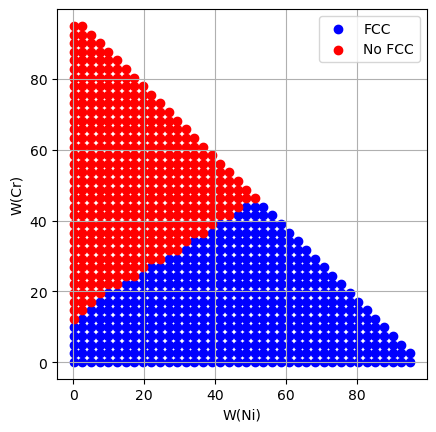

In [7]:
def filter_and_process(dataframe, func, columns=['Ni', 'Cr', 'Mo', 'Ti']):
    """Filter and process the dataframe."""
    filtered = dataframe.groupby(columns).filter(func)
    processed = filtered[columns].drop_duplicates().reset_index(drop=True)
    processed['Fe'] = 100 - processed[columns].sum(axis=1)
    return processed


# Filter data for 'Y' and 'N' values
compo_FullEquil_FCC_y = filter_and_process(
    df_FullEquil, lambda x: x['np(FCC_L12)_merge'].max() > 0.99)
compo_FullEquil_FCC_n = filter_and_process(
    df_FullEquil, lambda x: x['np(FCC_L12)_merge'].max() < 0.99)

# Display and plot
display(compo_FullEquil_FCC_y.head(3))
print(compo_FullEquil_FCC_y.shape)

# Scatter plot
plt.scatter(compo_FullEquil_FCC_y['Ni'], compo_FullEquil_FCC_y['Cr'],
            marker='o', color='blue', label='FCC')
plt.scatter(compo_FullEquil_FCC_n['Ni'], compo_FullEquil_FCC_n['Cr'],
            marker='o', color='red', label='No FCC')
plt.xlabel('W(Ni)')
plt.ylabel('W(Cr)')
plt.grid(True)
plt.xlim(0, 100)
plt.ylim(0, 100)
plt.axis('square')
plt.legend()
plt.show()


### Analyse Gmin results

- Gmin_results parallel processes data for 11 phases.
- Each phase yields:
  - Conditions
  - Data sets: gm("the phase").
- unpack these results into separate lists.
- This data is then structured into a concise DataFrame for easy analysis.
- Rows where the 'Gm_FCC_L12' value is minimal are filtered into df_Gmin_FCC.


In [8]:
# Using dictionary comprehension to extract lists of Gm values
Gm_values = {phase: Gmin_results[i][1]
             for i, phase in enumerate(Gmin_phase_list)}

# Only print first few items to check
print(len(Gmin_results[0][0]))
print(Gmin_results[0][0][0])

print(len(Gm_values['FCC_L12']))
print(Gm_values['FCC_L12'][0])

# Constructing the DataFrame
df_Gmin = pd.DataFrame({
    'Ni': [dict(conditions)['W(Ni)']*100 for conditions in Gmin_results[0][0]],
    'Cr': [dict(conditions)['W(Cr)']*100 for conditions in Gmin_results[0][0]],
    'Mo': [dict(conditions)['W(Mo)']*100 for conditions in Gmin_results[0][0]],
    'Ti': [dict(conditions)['W(Ti)']*100 for conditions in Gmin_results[0][0]],
    **{f'Gm_{phase}': Gm_values[phase] for phase in Gmin_phase_list}
})

df_Gmin.to_excel(os.path.join(current_directory,
                 "tc_df_Gmin_check.xlsx"), index=False)
display(df_Gmin.head(3))

859
(('W(Ni)', 0.001), ('W(Cr)', 0.001), ('W(Mo)', 0.001), ('W(Ti)', 0.001))
859
-10253.82369623779


,Ni,Cr,Mo,Ti,Gm_BCC_B2,Gm_FCC_L12,Gm_HEUSLER_L21,Gm_SIGMA,Gm_LIQUID,Gm_NI3TA_D0A,Gm_MU_PHASE,Gm_C14_LAVES,Gm_C15_LAVES,Gm_CHI_A12
0,0.1,0.100000,0.1,0.1,-14154.859082,-10253.823696,NaN,-839.401022,-663.895399,-4570.841487,20316.490322,-4609.182350,-4599.662929,NaN
1,0.1,2.533333,0.1,0.1,-14125.947453,-10419.603127,NaN,-2294.609177,-1251.304926,-5075.580009,17760.778991,-5135.332025,-5126.971261,NaN
2,0.1,4.966667,0.1,0.1,-13989.444276,-10459.120543,NaN,-3513.260982,-1693.238569,-5448.005547,15445.257948,-5530.062859,-5522.820739,NaN


In [9]:
# Filter rows where 'Gm_FCC_L12' has the minimum value among the columns to compare
columns_to_compare = [f'Gm_{phase}' for phase in Gmin_phase_list]
df_Gmin_FCC = df_Gmin[df_Gmin['Gm_FCC_L12'] ==
                      df_Gmin[columns_to_compare].min(axis=1)]

# Display and save
display(df_Gmin_FCC.head(3))
print(df_Gmin_FCC.shape)
# df_Gmin_FCC.to_excel(os.path.join(current_directory, "df_Gmin_FCC.xlsx"), index=False)

,Ni,Cr,Mo,Ti,Gm_BCC_B2,Gm_FCC_L12,Gm_HEUSLER_L21,Gm_SIGMA,Gm_LIQUID,Gm_NI3TA_D0A,Gm_MU_PHASE,Gm_C14_LAVES,Gm_C15_LAVES,Gm_CHI_A12
230,14.7,0.100000,0.1,0.1,-14864.571482,-32053.161577,NaN,-7876.593792,-3617.941296,-8800.867571,17885.876426,-6954.794576,-6912.704222,NaN
231,14.7,2.533333,0.1,0.1,-14928.688214,-32789.143088,NaN,-8778.806014,-4124.578981,-9227.466788,15426.961584,-7464.695344,-7424.056398,NaN
232,14.7,4.966667,0.1,0.1,-14874.555866,-33297.963773,NaN,-9476.480339,-4478.112230,-9521.575093,13210.393341,-7841.883859,-7802.650694,NaN


(400, 14)


### Filter the compo from Gmin results


,Ni,Cr,Mo,Ti,Fe
0,14.7,0.100000,0.1,0.1,85.000000
1,14.7,2.533333,0.1,0.1,82.566667
2,14.7,4.966667,0.1,0.1,80.133333


(400, 5)


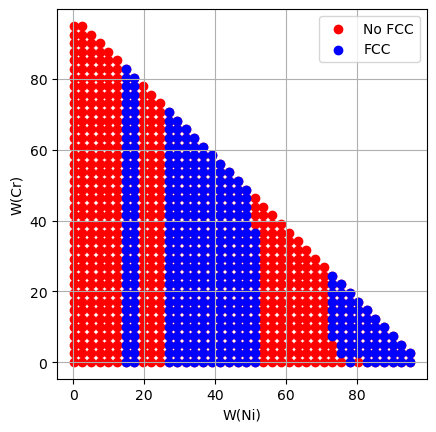

In [10]:
# Extract unique combinations of 'Ni', 'Cr', 'Mo', and 'Ti' from df_Gmin_FCC
compo_Gmin_FCC_y = df_Gmin_FCC[['Ni', 'Cr', 'Mo',
                                'Ti']].drop_duplicates().reset_index(drop=True)


compo_Gmin_FCC_all = df_Gmin[['Ni', 'Cr', 'Mo',
                              'Ti']].drop_duplicates().reset_index(drop=True)

# Compute 'Fe' values for each row
compo_Gmin_FCC_y['Fe'] = 100 - \
    (compo_Gmin_FCC_y[['Ni', 'Cr', 'Mo', 'Ti']].sum(axis=1))

compo_Gmin_FCC_all['Fe'] = 100 - \
    (compo_Gmin_FCC_all[['Ni', 'Cr', 'Mo', 'Ti']].sum(axis=1))

# Get the rows which are in compo_Gmin_FCC_all but not in compo_Gmin_FCC_y
compo_Gmin_FCC_n = pd.concat(
    [compo_Gmin_FCC_all, compo_Gmin_FCC_y, compo_Gmin_FCC_y]).drop_duplicates(keep=False)

# Display the first few rows and the shape of the dataframe
display(compo_Gmin_FCC_y.head(3))
print(compo_Gmin_FCC_y.shape)

# Scatter plot
plt.scatter(compo_Gmin_FCC_all['Ni'], compo_Gmin_FCC_all['Cr'],
            marker='o', color='red', label='No FCC')
plt.scatter(compo_Gmin_FCC_y['Ni'], compo_Gmin_FCC_y['Cr'],
            marker='o', color='blue', label='FCC')

plt.xlabel('W(Ni)')
plt.ylabel('W(Cr)')
plt.grid(True)
plt.xlim(0, 100)
plt.ylim(0, 100)
plt.axis('square')
plt.legend()
plt.show()

### Output shared compo space


(253, 5)


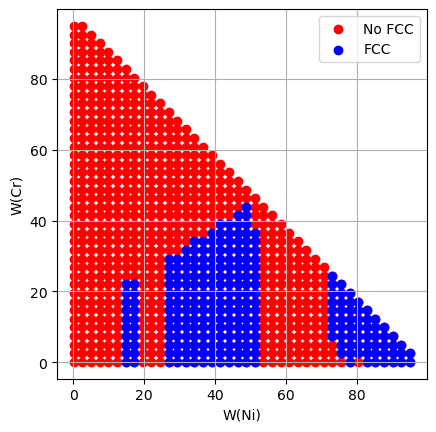

In [13]:
compo_FullEquil_Gmin_FCC_y = pd.merge(
    compo_Gmin_FCC_y, compo_FullEquil_FCC_y, how='inner')
print(compo_FullEquil_Gmin_FCC_y.shape)

# Scatter plot
plt.scatter(compo_Gmin_FCC_all['Ni'], compo_Gmin_FCC_all['Cr'],
            marker='o', color='red', label='No FCC')
plt.scatter(compo_FullEquil_Gmin_FCC_y['Ni'], compo_FullEquil_Gmin_FCC_y['Cr'],
            marker='o', color='blue', label='FCC')

plt.xlabel('W(Ni)')
plt.ylabel('W(Cr)')
plt.grid(True)
plt.xlim(0, 100)
plt.ylim(0, 100)
plt.axis('square')
plt.legend()
plt.show()

df_output_fname = "MultiTaskModel_NiCrFe_MoTi_TC_wt_pct.xlsx"

compo_FullEquil_Gmin_FCC_y.to_excel(
    os.path.join(current_directory, df_output_fname), index=False)